# 交易策略

In [1]:
from datetime import datetime
from typing import Tuple, List

import ffn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 准备数据

In [4]:
# 历史价格
ohlcv = pd.read_csv("./btcusd.csv", index_col="date", parse_dates=True)

# 预测概率
preds = pd.read_csv("./predictions.csv", index_col="date", parse_dates=True)

# 合并数据
df = ohlcv.join(preds, on="date", how="left").dropna()
df.round(2)

,open,high,low,close,volume,bearish_prob,neutral_prob,bullish_prob
date,,,,,,,,
2018-01-07,17527.30,17579.60,16087.70,16477.60,15866000384,0.0,0.00,1.00
2018-01-08,16476.20,16537.90,14208.20,15170.10,18413899776,0.0,0.43,0.57
2018-01-09,15123.70,15497.50,14424.00,14595.40,16659999744,0.0,0.06,0.94
2018-01-10,14588.50,14973.30,13691.20,14973.30,18500800512,0.0,0.52,0.48
2018-01-11,14968.20,15018.80,13105.90,13405.80,16534099968,0.0,0.16,0.83
...,...,...,...,...,...,...,...,...
2024-12-26,99297.70,99884.57,95137.88,95795.52,47054980873,0.0,0.80,0.20
2024-12-27,95704.98,97294.84,93310.74,94164.86,52419934565,0.0,1.00,0.00
2024-12-28,94160.19,95525.90,94014.29,95163.93,24107436185,0.0,0.98,0.01


## 可视化预测概率

In [5]:
def find_probability_periods(
    df: pd.DataFrame, probability_threshold: float = 0.7
) -> List[Tuple[datetime, datetime, str]]:
    """
    识别上涨、下跌和震荡概率超过阈值的连续时期。

    Args:
        data: 包含概率的数据框，包含字段 'bullish_prob', 'neutral_prob', 'bearish_prob'。
        probability_threshold: 概率阈值，默认为 0.7。

    Returns:
        一个列表，包含 (开始日期, 结束日期, 状态) 的元组。
    """

    periods = []
    start_date = None
    current_state = None

    for date, row in df.iterrows():
        up_prob = row["bullish_prob"]
        down_prob = row["bearish_prob"]
        neutral_prob = row["neutral_prob"]

        if up_prob > probability_threshold:
            state = "up"
        elif down_prob > probability_threshold:
            state = "down"
        elif neutral_prob > probability_threshold:
            state = "neutral"
        else:
            state = None

        if state:
            if state == current_state:
                continue
            else:
                if start_date:
                    periods.append((start_date, date, current_state))
                start_date = date
                current_state = state
        else:
            if start_date:
                periods.append((start_date, date, current_state))
            start_date = None
            current_state = None

    # 处理最后一个时期
    if start_date:
        periods.append((start_date, df.index[-1], current_state))

    return periods

In [6]:
# 概率阈值
probability_threshold = 0.7
periods = find_probability_periods(df, probability_threshold)

# 创建图表对象
fig = go.Figure()

# 添加收盘价折线图
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["close"],
        line=dict(color="blue"),
    )
)

# 添加颜色带
for start_date, end_date, state in periods:
    color = None
    if state == "up":
        color = "rgba(144, 238, 144, 0.5)"  # 浅绿色
    elif state == "down":
        color = "rgba(240, 128, 128, 0.5)"  # 浅红色
    elif state == "neutral":
        color = "rgba(211, 211, 211, 0.5)"  # 浅灰色

    fig.add_vrect(
        x0=start_date,
        x1=end_date,
        fillcolor=color,
        opacity=0.7,
        layer="below",
        line_width=0,
    )

# 更新布局
fig.update_layout(
    title="Visulaize Predicted Probability",
    width=1200,
    height=800,
    template="plotly_white",
)

fig.show()

## 交易策略

- 当上涨概率超过设定阈值（例如0.7），做多
- 当下跌概率超过设定阈值（例如0.7），做空
- 其余时期空仓

回溯检验方法：向量化回溯检验。

In [23]:
def backtest(
    bullish_prob: pd.Series,
    bearish_prob: pd.Series,
    closes: pd.Series,
    probability_threshold: float = 0.5,
    initial_capital: int = 10000,
) -> pd.DataFrame:
    # 生成头寸/信号，1表示做多，-1表示做空，0表示观望
    position = np.where(bullish_prob >= probability_threshold, 1, 0)
    # position = np.where(bearish_prob >= probability_threshold, -1, position)
    position = pd.Series(position, index=closes.index)

    # 计算策略收益率，必须用前一个交易日的头寸乘以当天的收益率，否则会产生前视偏误
    rets = np.log(closes / closes.shift(1))
    strategy_rets = position.shift(1) * rets

    # 累计收益率
    cum_returns = strategy_rets.fillna(0).cumsum()

    # 净值曲线
    equity = initial_capital * (1 + cum_returns)

    df = pd.concat([closes, position, equity], axis=1)
    df.columns = ["close", "position", "equity"]

    return df


res = backtest(df["bullish_prob"], df["bearish_prob"], df["close"], 0.8)
stats = ffn.calc_perf_stats(res["equity"], annualization_factor=365)
stats.display()

Stats for equity from 2018-01-07 00:00:00 - 2024-12-30 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
294.53%             1.21  21.73%  -24.37%

Annualized Returns:
mtd     3m     6m     ytd     1y      3y     5y      10y    incep.
------  -----  -----  ------  ------  -----  ------  -----  --------
-1.09%  4.49%  4.26%  10.43%  10.51%  7.17%  19.32%  -      21.73%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.21     0.96       1.06
mean    21.19%   21.97%     28.42%
vol     17.56%   22.85%     26.81%
skew    1.14     4.16       0.54
kurt    27.70    23.56      -1.34
best    10.02%   45.39%     66.67%
worst   -8.27%   -8.86%     -2.51%

Drawdowns:
max      avg       # days
-------  ------  --------
-24.37%  -3.14%     44.87

Misc:
---------------  ------
avg. up month    8.40%
avg. down month  -0.69%
up year %        83.33%
12m up %  

In [24]:
# 创建图表对象
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("BTCUSD Close prices", "Signal/Position", "Strategy equity curve"),
)

# 添加收盘价折线图
fig.add_trace(go.Scatter(x=res.index, y=res["close"]), row=1, col=1)

# 信号/头寸
fig.add_trace(go.Scatter(x=res.index, y=res["position"]), row=2, col=1)

# 策略收益率
fig.add_trace(go.Scatter(x=res.index, y=res["equity"]), row=3, col=1)

# 更新布局
fig.update_layout(
    title="Backtest strategy",
    width=1200,
    height=800,
    template="plotly_white",
    showlegend=False,
)

fig.show()

## 调整概率阈值

In [25]:
# 参数扫描区间
probability_threshold_range = np.arange(0.5, 0.91, 0.02)

# 记录夏普比率
sharpe_ratios = []

# 使用不同的概率阈值进行回测
for prob in probability_threshold_range:
    res = backtest(df["bullish_prob"], df["bearish_prob"], df["close"], prob, 10000)
    stats = ffn.calc_perf_stats(res["equity"], annualization_factor=365)
    sharpe_ratios.append(stats.daily_sharpe)

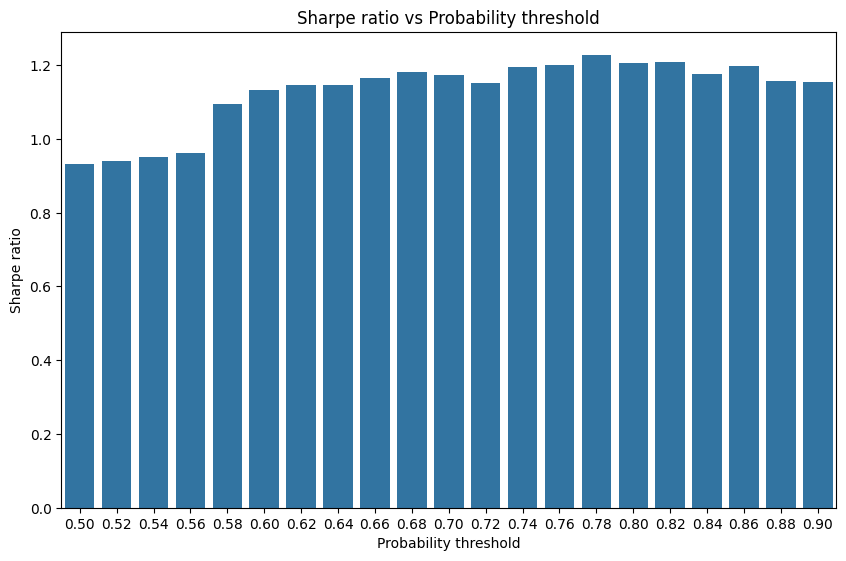

In [27]:
fig, ax = plt.subplots(figsize=(10, 6.18))
xlabels = [f"{x:.2f}" for x in probability_threshold_range]
sns.barplot(x=xlabels, y=sharpe_ratios, ax=ax)
ax.set_title("Sharpe ratio vs Probability threshold")
ax.set_xlabel("Probability threshold")
_ = ax.set_ylabel("Sharpe ratio")